# Calculate quasi-geostrophic vorticity terms from SSH data

In [1]:
%run ../../_setup.py

from xarray import open_dataset
from netCDF4 import Dataset, num2date
from oceanpy.netcdf import createNetCDF
from shutil import copyfile

import numpy as np
from scipy.interpolate import griddata
from stsci.convolve import boxcar
import pyproj

from gsw import f

import matplotlib.pyplot as plt
import cmocean as cmo


In [2]:
# load altimetry/ gradient wind data from selection of data
west = 135
south = -53.4
east = 149
north = -47

# west = 137
# south = -52.4
# east = 147
# north = -48

input_file_gw = os.path.join(datadir, 'external', 'ssh', 'processed',
                             'rep_allsat_phy_l4_%s_%s_%s_%s_199803_gw.nc' %(west, int(south), east, int(north)))
ssh = Dataset(input_file_gw)
gw = open_dataset(input_file_gw, group='GW')

In [3]:
output_file_qgvb = os.path.join(datadir, 'external', 'ssh', 'processed', 
                                'rep_allsat_phy_l4_%s_%s_%s_%s_199803_qgvb.nc' %(west, int(south), east, int(north)))

In [4]:
# mesh geographic grid
loni, lati = gw.longitude.data, gw.latitude.data
lnln, ltlt = np.meshgrid(loni, lati)

# transform polar in cartesian coordinate system
UTM54 = pyproj.Proj('+proj=utm +zone=54F +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
WGS84 = pyproj.Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
xx, yy = pyproj.transform(WGS84, UTM54, lnln, ltlt)

# calculate ageostrophic components from gradient wind velocities
uag = gw.ugrad - gw.ugeos
vag = gw.vgrad - gw.vgeos

# calculate Coriolis parameters
fcor = f(ltlt)
beta = np.gradient(fcor)[0] / np.gradient(yy)[0]

/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  


## calculate quasigeostrophic vortivity budget terms


In [5]:
def interp(var, xx, yy):
    finite = np.isfinite(var).flatten()
    if not all(finite):
        points = np.array((xx.flatten(), yy.flatten())).T
        values = var.flatten()
        var = griddata(points[finite], values[finite], points).reshape(xx.shape)
    return var

smooth = True
grid_point = (3, 3)

zeta = np.ma.masked_all(gw.ugrad.shape)
divgeos, divag = zeta.copy(), zeta.copy()
fdwdz, betav, ugradzeta = zeta.copy(), zeta.copy(), zeta.copy()
ow, ow_norm = zeta.copy(), zeta.copy()
for t in range(len(gw.time)):

    # (gradients of) relative vorticity
    dvdx = np.gradient(gw.vgrad[t,])[1] / np.gradient(xx)[1]
    dvdx = boxcar(interp(dvdx, lnln, ltlt), grid_point) if smooth else dvdx
    dudy = np.gradient(gw.ugrad[t,])[0] / np.gradient(yy)[0]
    dudy = boxcar(interp(dudy, lnln, ltlt), grid_point) if smooth else dudy

    zeta[t,] = dvdx - dudy
        
    dzetadx = boxcar(np.gradient(zeta[t,])[1] / np.gradient(xx)[1], grid_point)
    dzetady = boxcar(np.gradient(zeta[t,])[0] / np.gradient(yy)[0], grid_point)
    
    # normal and shear components of strain and Okubo-Weiss parameter
    dudx = np.gradient(gw.ugrad[t,])[1] / np.gradient(xx)[1]
    dudx = boxcar(interp(dudx, lnln, ltlt), grid_point) if smooth else dudx
    dvdy = np.gradient(gw.vgrad[t,])[0] / np.gradient(yy)[0]
    dvdy = boxcar(interp(dvdy, lnln, ltlt), grid_point) if smooth else dvdy
    
    sn = dudx - dvdy
    ss = dvdx + dudy
    
    ow[t,] = sn**2 + ss**2 - zeta[t,]**2
    W0 = 0.2 * np.nanstd(ow[t,])
    ow_norm[t,] = ow[t,] / W0
    ow[t,] = ow[t,] / 4
    
    # divergence of velocity field
    duagdx = np.gradient(uag[t,])[1] / np.gradient(xx)[1]
    duagdx = boxcar(interp(duagdx, lnln, ltlt), grid_point) if smooth else duagdx
    dvagdy = np.gradient(vag[t,])[0] / np.gradient(yy)[0]
    dvagdy = boxcar(interp(dvagdy, lnln, ltlt), grid_point) if smooth else dvagdy
    
    divag[t,] = duagdx + dvagdy
    
    # calculate vortivity budget terms
    fdwdz[t,] = - fcor * (duagdx + dvagdy)# - (beta * gw.vgeos[t,])
    betav[t,] = beta * gw.vgrad[t,]
    ugradzeta[t,] = (gw.ugrad[t,] * dzetadx) + (gw.vgrad[t,] * dzetady)

    del dvdx, dudy, dudx, dvdy, sn, ss, duagdx, dvagdy, dzetadx, dzetady

# local time derivative of relative vorticity
dt = np.gradient(gw.time).astype('timedelta64[s]')
dzetadt = np.gradient(zeta)[0] / np.unique(dt).astype('float')


## store quasi-geostrophic vorticity terms in netcdf

In [6]:
group = 'QGVB'

dimensions = {
    'time': gw['time'].size,
    'latitude': gw['latitude'].size,
    'longitude': gw['longitude'].size
}

variables = {
    'zeta': ('ocean_relative_vorticity', 'f8'),
    'dzetadt': ('unsteady_relative_vorticity', 'f8'),
    'fdwdz': ('vortex_stretching', 'f8'),
    'betav': ('planetary_vorticity_advection', 'f8'),
    'ugradzeta': ('relative_vorticity_advection', 'f8'),
    'divag': ('divergence_of_velocity', 'f8'),
    'ow': ('okubo_weiss_parameter', 'f8'),
    'ow_norm': ('normalised_okubo_weiss_parameter', 'f8')
}

In [7]:
new_variables = {}
for var in variables:
    new_variables['/%s/%s' %(group, var)] = variables[var] + (tuple(dimensions.keys()),) + (locals()[var],)

In [8]:
# load file and variables
if os.path.isfile(output_file_qgvb):
    print('Output file %s already exists.' %os.path.basename(output_file_qgvb))
    
    # load quasi-geostrophic vorticity balance
    qgvb = open_dataset(output_file_qgvb, group='QGVB')
else:
    copyfile(input_file_gw, output_file_qgvb)    
    print('Output file %s, copied from input file %s.'
          %(os.path.basename(output_file_qgvb), os.path.basename(input_file_gw)))
    
    # load quasi-geostrophic vorticity terms on ssh field
    qgvb  = createNetCDF(output_file_qgvb)

Output file rep_allsat_phy_l4_135_-53_149_-47_199803_qgvb.nc, copied from input file rep_allsat_phy_l4_135_-53_149_-47_199803_gw.nc.


In [9]:
try: 
    # create group
    dsgroup = qgvb.dataset.createGroup(group)

    # create dimensions and coordinates
    for name, size in dimensions.items():
        dsgroup.createDimension(name, size)
        if name in dimensions:
            if name == 'time':
                values = num2date(ssh[name][:], units=ssh[name].units, calendar=ssh[name].calendar)
            else:            
                values = ssh[name][:]
            new_variables['/%s/%s' %(group, name)] = (name, 'f8', name, values)

    # create variables
    qgvb.create_vars(new_variables)
    
except AttributeError:
    print('Output file already exists. Nothing is added to the netCDF file.')

qgvb.close()


/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  # Remove the CWD from sys.path while we load stuff.


## interpolate quasi-geostrophic velocity terms to CTD locations

In [10]:
# load ctd data
input_file_ctd = os.path.join(datadir, 'ss9802', 'processed', 'ctd', 'ss9802_ctd.nc')
ctd = Dataset(input_file_ctd, 'r')

qgvb = open_dataset(output_file_qgvb, group='QGVB')


In [11]:
# output files
input_file_gw_ctd = os.path.join(datadir, 'external', 'ssh', 'processed', 'rep_allsat_phy_l4_ss9802_gw_ctd.nc')
output_file_qgvb_ctd = os.path.join(datadir, 'external', 'ssh', 'processed', 'rep_allsat_phy_l4_ss9802_qgvb_ctd.nc')


In [12]:
# CTD dimensions
lon_ctd, lat_ctd = ctd['lon'][:, 0], ctd['lat'][:, 0]
time = num2date(ctd['time'][:, 0], ctd['time'].units)
time_str = [t.strftime('%Y-%m-%d') for t in time]
time_voy = slice('1998-03-12', '1998-03-28')

# SSH dimensions
time_str_ssh = np.datetime_as_string(qgvb.time, unit='D')

/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
group = 'CTD'

dimensions = {
    'time': time.size,
    'latitude': lat_ctd.size,
    'longitude': lon_ctd.size
}

In [14]:
lnln, ltlt = np.meshgrid(qgvb.longitude, qgvb.latitude)
points = np.array((lnln.flatten(), ltlt.flatten())).T

new_variables = {}
for var in variables:
    data = np.ma.masked_all((time.size,))
    for i in range(2, data.size):
        values = qgvb[var].sel(time=time_str[i]).values.flatten()
        data[i,] = griddata(points, values, (lon_ctd[i], lat_ctd[i]))
    new_variables['/%s/%s' %(group, var)] = variables[var] + ('time',) + (data,)

In [15]:
# load file and variables
if os.path.isfile(output_file_qgvb_ctd):
    print('Output file %s already exists.' %os.path.basename(output_file_qgvb_ctd))
    qgvb_ctd = open_dataset(output_file_qgvb_ctd, 'CTD')
else:
    copyfile(input_file_gw_ctd, output_file_qgvb_ctd)
    print('Output file %s, copied from input file %s.'
          %(os.path.basename(output_file_qgvb_ctd), os.path.basename(input_file_gw_ctd)))
    qgvb_ctd  = createNetCDF(output_file_qgvb_ctd)

Output file rep_allsat_phy_l4_ss9802_qgvb_ctd.nc, copied from input file rep_allsat_phy_l4_ss9802_gw_ctd.nc.


In [16]:
try: 
    # create variables
    qgvb_ctd.create_vars(new_variables)
except AttributeError:
    print('Output file already exists. Nothing is added to the netCDF file.')

qgvb_ctd.close()


## open quasi-geostrophic vorticity terms and check data


In [17]:
ssh = open_dataset(input_file_gw)
qgvb_ctd = open_dataset(output_file_qgvb_ctd, 'CTD')

/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


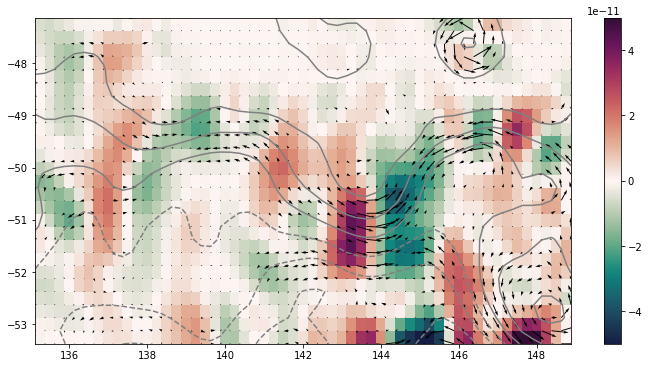

In [18]:
vmin, vmax = -5e-11, 5e-11

fig, ax = plt.subplots(figsize=(12, 6))
pcol = ax.pcolormesh(qgvb.longitude, qgvb.latitude, qgvb.fdwdz.mean('time'), 
                     vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
fig.colorbar(pcol)

ct = plt.contour(ssh.longitude, ssh.latitude, ssh.adt.mean('time'), colors='gray')

quiv = ax.quiver(ssh.longitude, ssh.latitude, uag.mean('time'), vag.mean('time'), 
                 units='inches', scale=0.1, width=1.1e-3*fig.get_size_inches()[0], color='k')


In [19]:
W = np.ma.masked_all(qgvb.ow.shape)
for t in range(len(qgvb.time)):
    W0 = 0.2 * np.nanstd(qgvb.ow[t,])
    W[t,] = qgvb.ow[t,] / W0

/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


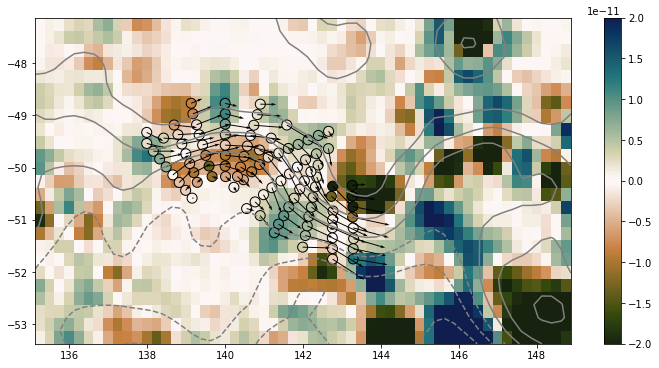

In [20]:
var ='ow'
cmap = cmo.cm.tarn # plt.cm.seismic
vmin, vmax = -2e-11, 2e-11 #-1.5e-5, 1.5e-5 #

fig, ax = plt.subplots(figsize=(12, 6))
ct = plt.contour(ssh.longitude, ssh.latitude, ssh.adt.mean('time'), colors='gray')

pcol = plt.pcolormesh(qgvb.longitude, qgvb.latitude, qgvb[var].mean('time'), 
                      cmap=cmap, vmin=vmin, vmax=vmax)
fig.colorbar(pcol)
scat = ax.scatter(qgvb_ctd.longitude[2:], qgvb_ctd.latitude[2:], c=qgvb_ctd[var][2:], 
                  cmap=cmap, vmin=vmin, vmax=vmax, s=100, edgecolors='k')

quiv = ax.quiver(qgvb_ctd.longitude[2:], qgvb_ctd.latitude[2:], 
                 qgvb_ctd.ugrad[2:], qgvb_ctd.vgrad[2:], 
                 units='inches', scale=1, width=1.1e-3*fig.get_size_inches()[0], color='k')
qk = plt.quiverkey(quiv, .72, 0.99, 1, r'0.1 ms$^{-1}$', labelpos='E', coordinates='figure')

(-7e-11, 7e-11)

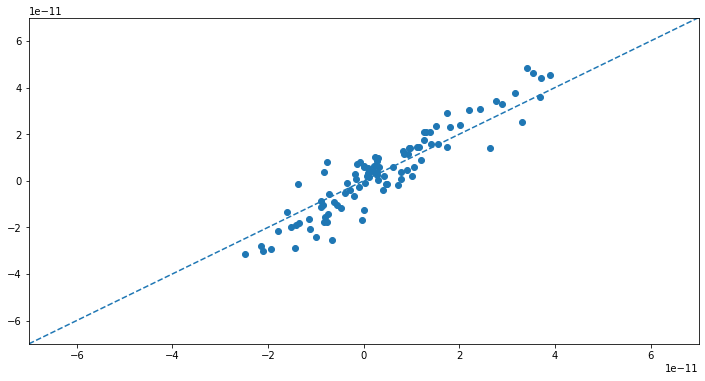

In [21]:
xmin, xmax = -7e-11, 7e-11
xi = np.linspace(xmin, xmax)


fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(qgvb_ctd.fdwdz, qgvb_ctd.ugradzeta)
plt.plot(xi, xi, linestyle='--')


ax.set_xlim([xmin, xmax])
ax.set_ylim([xmin, xmax])